In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.optimizers import SGD, RMSprop, Adam, Adamax

Using TensorFlow backend.


In [2]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [3]:
env = gym.make('LunarLander-v2')


In [4]:
# build a set of samples so we can get a scaler fitted.
observation_samples = []

n_samples = 1000
# play a bunch of games randomly and collect observations
done = False
for n in range(n_samples):
    observation = env.reset()
    observation_samples.append(observation)
    done = False
    while not done:
        action = np.random.randint(0, env.action_space.n)
        observation, reward, done, _ = env.step(action)
        observation_samples.append(observation)
    #print(len(observation_samples))
    

observation_samples = np.array(observation_samples)

In [5]:
env = wrappers.Monitor(env, 'monitor-folder', force=True)


In [6]:
scaler = StandardScaler()
scaler.fit(observation_samples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:

def create_nn():
    model = Sequential()
    model.add(Dense(128, kernel_initializer='lecun_uniform', input_shape=(8,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3)) #I'm not using dropout, but maybe you wanna give it a try?

    model.add(Dense(256, kernel_initializer='lecun_uniform'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='lecun_uniform'))
    model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

#     rms = RMSprop(lr=0.005)
#     sgd = SGD(lr=0.1, decay=0.0, momentum=0.0, nesterov=False)
# try "adam"
#     adam = Adam(lr=0.0005)
    adamax = Adamax() #Adamax(lr=0.001)
    model.compile(loss='mse', optimizer=adamax)
#     model.summary()
    return model

In [8]:
class Model:
  def __init__(self, env, scaler):
    self.env = env
    self.scaler = scaler
    self.models = []
    for i in range(env.action_space.n):
        model = create_nn()  # one nn per action
        self.models.append(model) 

  def predict(self, s):
    X = self.scaler.transform(np.atleast_2d(s))
    return np.array([m.predict(np.array(X), verbose=0)[0] for m in self.models])

  def update(self, s, a, G):
    X = self.scaler.transform(np.atleast_2d(s))
    self.models[a].fit(np.array(X), np.array([G]), epochs=1, verbose=0)

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

In [9]:
def play_one(env, model, eps, gamma):
  observation = env.reset()
  done = False
  full_reward_received = False
  totalreward = 0
  iters = 0
  while not done:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)
            
    # update the model
    # standard Q learning TD(0)
    next = model.predict(observation)
    G = reward + gamma*np.max(next)
    model.update(prev_observation, action, G)
    totalreward += reward
    iters += 1
    
  return totalreward, iters

episode: 0 iters 104 total reward: -128.829963422 eps: 1.0 avg reward (last 100): -128.829963422
episode: 10 iters 130 total reward: -35.503976892 eps: 0.301511344578 avg reward (last 100): -204.166654837
episode: 20 iters 133 total reward: -303.859786327 eps: 0.218217890236 avg reward (last 100): -243.059944703
episode: 30 iters 113 total reward: -53.0602596272 eps: 0.179605302027 avg reward (last 100): -249.797985645
episode: 40 iters 120 total reward: -225.168595678 eps: 0.156173761889 avg reward (last 100): -262.88297601
episode: 50 iters 206 total reward: -469.609702614 eps: 0.140028008403 avg reward (last 100): -268.766727151
episode: 60 iters 96 total reward: -326.36789393 eps: 0.128036879933 avg reward (last 100): -267.975924738
episode: 70 iters 182 total reward: -316.335971483 eps: 0.118678165819 avg reward (last 100): -272.480821803
episode: 80 iters 246 total reward: -289.253962551 eps: 0.111111111111 avg reward (last 100): -278.208878609
episode: 90 iters 203 total reward:

episode: 750 iters 1000 total reward: -135.188275811 eps: 0.0364905182584 avg reward (last 100): -173.38012377
episode: 760 iters 1000 total reward: -121.912311056 eps: 0.0362499716797 avg reward (last 100): -172.206411621
episode: 770 iters 1000 total reward: -77.537787034 eps: 0.0360141203033 avg reward (last 100): -167.842947938
episode: 780 iters 1000 total reward: -141.876287826 eps: 0.0357828133482 avg reward (last 100): -161.159765695
episode: 790 iters 1000 total reward: -96.8382433664 eps: 0.0355559067267 avg reward (last 100): -148.96321798
episode: 800 iters 1000 total reward: -134.590372563 eps: 0.0353332626669 avg reward (last 100): -144.286157763
episode: 810 iters 1000 total reward: -18.4598797766 eps: 0.035114749361 avg reward (last 100): -143.513710416
episode: 820 iters 1000 total reward: -126.52550193 eps: 0.034900240638 avg reward (last 100): -132.367235868
episode: 830 iters 1000 total reward: -132.465848189 eps: 0.0346896156568 avg reward (last 100): -128.16235404

episode: 1480 iters 1000 total reward: -111.339984356 eps: 0.0259849850167 avg reward (last 100): -141.445774212
episode: 1490 iters 1000 total reward: -125.286321838 eps: 0.0258976989622 avg reward (last 100): -139.851560353
episode: 1500 iters 211 total reward: -134.974495581 eps: 0.025811286646 avg reward (last 100): -137.383382792
episode: 1510 iters 1000 total reward: -120.22840747 eps: 0.0257257335878 avg reward (last 100): -136.969159217
episode: 1520 iters 703 total reward: -191.241087695 eps: 0.025641025641 avg reward (last 100): -137.064674995
episode: 1530 iters 1000 total reward: -167.297527975 eps: 0.025557148983 avg reward (last 100): -136.417408691
episode: 1540 iters 1000 total reward: -131.00078578 eps: 0.0254740901056 avg reward (last 100): -135.528106294
episode: 1550 iters 413 total reward: -154.629280067 eps: 0.025391835806 avg reward (last 100): -133.754568626
episode: 1560 iters 1000 total reward: -137.321728159 eps: 0.0253103731776 avg reward (last 100): -133.54

episode: 2210 iters 287 total reward: -138.101920413 eps: 0.021266970503 avg reward (last 100): -139.44437063
episode: 2220 iters 164 total reward: -114.585045254 eps: 0.021219039474 avg reward (last 100): -138.636449602
episode: 2230 iters 1000 total reward: -125.421111958 eps: 0.0211714310688 avg reward (last 100): -137.492383557
episode: 2240 iters 308 total reward: -130.974992237 eps: 0.0211241416841 avg reward (last 100): -137.204397965
episode: 2250 iters 1000 total reward: -133.935690564 eps: 0.021077167773 avg reward (last 100): -137.562967118
episode: 2260 iters 1000 total reward: -144.348151031 eps: 0.0210305058434 avg reward (last 100): -137.187475393
episode: 2270 iters 1000 total reward: -153.26674419 eps: 0.020984152457 avg reward (last 100): -138.840189835
episode: 2280 iters 1000 total reward: -118.451523975 eps: 0.0209381042284 avg reward (last 100): -138.625235153
episode: 2290 iters 1000 total reward: -142.514275625 eps: 0.0208923578241 avg reward (last 100): -137.67

episode: 2950 iters 131 total reward: -168.560380775 eps: 0.0184083725592 avg reward (last 100): -166.515293638
episode: 2960 iters 154 total reward: -249.628017793 eps: 0.0183772615473 avg reward (last 100): -176.022231462
episode: 2970 iters 339 total reward: -160.305195408 eps: 0.0183463077414 avg reward (last 100): -169.002059246
episode: 2980 iters 206 total reward: -500.540862856 eps: 0.0183155098218 avg reward (last 100): -179.585115369
episode: 2990 iters 810 total reward: -255.497194775 eps: 0.0182848664846 avg reward (last 100): -184.601114317
episode: 3000 iters 306 total reward: -152.149652131 eps: 0.0182543764409 avg reward (last 100): -187.781965948
episode: 3010 iters 1000 total reward: -138.981071832 eps: 0.0182240384169 avg reward (last 100): -189.778147174
episode: 3020 iters 248 total reward: -131.312198461 eps: 0.0181938511535 avg reward (last 100): -193.849970025
episode: 3030 iters 1000 total reward: -271.965996185 eps: 0.0181638134061 avg reward (last 100): -197.

episode: 3690 iters 208 total reward: -120.734954294 eps: 0.0164599297525 avg reward (last 100): -157.131728962
episode: 3700 iters 947 total reward: -263.885618072 eps: 0.0164376775728 avg reward (last 100): -156.323506272
episode: 3710 iters 189 total reward: -108.384695752 eps: 0.016415515398 avg reward (last 100): -156.737758083
episode: 3720 iters 1000 total reward: -138.814644381 eps: 0.016393442623 avg reward (last 100): -158.879037054
episode: 3730 iters 182 total reward: -147.466891636 eps: 0.0163714586482 avg reward (last 100): -161.143464182
episode: 3740 iters 1000 total reward: -150.159364074 eps: 0.0163495628798 avg reward (last 100): -158.23548186
episode: 3750 iters 1000 total reward: -176.841624914 eps: 0.0163277547297 avg reward (last 100): -159.028460105
episode: 3760 iters 1000 total reward: -85.7736600916 eps: 0.016306033615 avg reward (last 100): -159.014459959
episode: 3770 iters 1000 total reward: -151.352507049 eps: 0.0162843989582 avg reward (last 100): -171.3

episode: 4430 iters 1000 total reward: -138.715234661 eps: 0.0150227391024 avg reward (last 100): -147.401083741
episode: 4440 iters 978 total reward: -265.458706402 eps: 0.0150058158807 avg reward (last 100): -150.824324205
episode: 4450 iters 347 total reward: -157.460344616 eps: 0.0149889497229 avg reward (last 100): -152.139693951
episode: 4460 iters 331 total reward: -169.82535347 eps: 0.0149721403089 avg reward (last 100): -155.4455185
episode: 4470 iters 189 total reward: -138.578002201 eps: 0.0149553873213 avg reward (last 100): -154.81342025
episode: 4480 iters 521 total reward: -168.731388898 eps: 0.0149386904452 avg reward (last 100): -155.326182642
episode: 4490 iters 125 total reward: -126.612960078 eps: 0.0149220493679 avg reward (last 100): -159.22780748
episode: 4500 iters 173 total reward: -140.971320891 eps: 0.0149054637794 avg reward (last 100): -159.610302456
episode: 4510 iters 1000 total reward: -124.904457544 eps: 0.0148889333719 avg reward (last 100): -160.38462

episode: 5170 iters 189 total reward: -144.375433068 eps: 0.0139063364056 avg reward (last 100): -141.764289189
episode: 5180 iters 1000 total reward: -133.813856588 eps: 0.0138929094097 avg reward (last 100): -141.984951688
episode: 5190 iters 1000 total reward: -144.330768897 eps: 0.0138795212314 avg reward (last 100): -143.022624799
episode: 5200 iters 1000 total reward: -158.356045476 eps: 0.013866171684 avg reward (last 100): -144.624971603
episode: 5210 iters 1000 total reward: -128.671273568 eps: 0.0138528605821 avg reward (last 100): -144.343582873
episode: 5220 iters 927 total reward: -263.259295102 eps: 0.0138395877414 avg reward (last 100): -145.197345618
episode: 5230 iters 1000 total reward: -142.936886354 eps: 0.0138263529792 avg reward (last 100): -144.91011057
episode: 5240 iters 253 total reward: -170.366780918 eps: 0.0138131561135 avg reward (last 100): -145.187687188
episode: 5250 iters 1000 total reward: -113.282693888 eps: 0.013799996964 avg reward (last 100): -145

episode: 5900 iters 1000 total reward: -124.69912418 eps: 0.0130177879425 avg reward (last 100): -139.223554283
episode: 5910 iters 290 total reward: -148.252841906 eps: 0.0130067717875 avg reward (last 100): -138.178232553
episode: 5920 iters 1000 total reward: -136.307719012 eps: 0.0129957835522 avg reward (last 100): -143.387783003
episode: 5930 iters 1000 total reward: -92.8582307488 eps: 0.0129848231189 avg reward (last 100): -143.531009095
episode: 5940 iters 1000 total reward: -138.474343697 eps: 0.0129738903703 avg reward (last 100): -144.476213548
episode: 5950 iters 1000 total reward: -124.809443374 eps: 0.0129629851903 avg reward (last 100): -139.276677668
episode: 5960 iters 1000 total reward: -117.851380656 eps: 0.0129521074631 avg reward (last 100): -141.702054116
episode: 5970 iters 1000 total reward: -169.218489454 eps: 0.0129412570738 avg reward (last 100): -143.097255669
episode: 5980 iters 1000 total reward: -147.682605007 eps: 0.012930433908 avg reward (last 100): -

episode: 6630 iters 1000 total reward: -117.344531702 eps: 0.0122803426853 avg reward (last 100): -138.66578379
episode: 6640 iters 1000 total reward: -140.179707636 eps: 0.0122710933485 avg reward (last 100): -138.166378215
episode: 6650 iters 233 total reward: -120.293034075 eps: 0.0122618648796 avg reward (last 100): -138.31069894
episode: 6660 iters 1000 total reward: -135.935411776 eps: 0.0122526572003 avg reward (last 100): -137.511321756
episode: 6670 iters 1000 total reward: -146.194427625 eps: 0.0122434702325 avg reward (last 100): -139.004077518
episode: 6680 iters 186 total reward: -154.355809683 eps: 0.0122343038988 avg reward (last 100): -138.918461693
episode: 6690 iters 1000 total reward: -115.43983191 eps: 0.012225158122 avg reward (last 100): -139.144589825
episode: 6700 iters 1000 total reward: -141.918041794 eps: 0.0122160328254 avg reward (last 100): -139.331776846
episode: 6710 iters 1000 total reward: -126.162403128 eps: 0.0122069279327 avg reward (last 100): -138

episode: 7360 iters 1000 total reward: -123.970559654 eps: 0.0116555183148 avg reward (last 100): -139.180775066
episode: 7370 iters 1000 total reward: -143.788869465 eps: 0.0116476092969 avg reward (last 100): -139.450667498
episode: 7380 iters 150 total reward: -143.368536822 eps: 0.0116397163575 avg reward (last 100): -139.551148231
episode: 7390 iters 1000 total reward: -128.946365691 eps: 0.0116318394423 avg reward (last 100): -138.866439519
episode: 7400 iters 1000 total reward: -126.552519254 eps: 0.011623978497 avg reward (last 100): -138.859608899
episode: 7410 iters 1000 total reward: -139.036260696 eps: 0.0116161334677 avg reward (last 100): -138.264675492
episode: 7420 iters 1000 total reward: -129.079876751 eps: 0.0116083043009 avg reward (last 100): -138.9383076
episode: 7430 iters 1000 total reward: -129.63457941 eps: 0.0116004909432 avg reward (last 100): -138.019519706
episode: 7440 iters 1000 total reward: -154.586610313 eps: 0.0115926933413 avg reward (last 100): -13

episode: 8090 iters 1000 total reward: -145.396683042 eps: 0.0111172890994 avg reward (last 100): -136.824088545
avg reward for last 100 episodes: -136.408777976
total steps: -1279095.77911


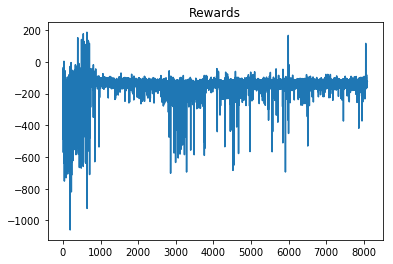

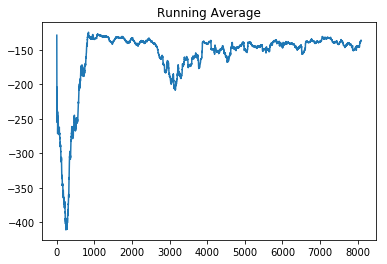

In [10]:
model = Model(env, scaler)
gamma = 0.99

N = 8096
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward, iters = play_one(env, model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 10 == 0:
      print("episode:", n, "iters", iters, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
    if totalrewards[max(0, n-100):(n+1)].mean() >= 200:
        break

print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)